# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset
- Visualize the German Traffic Signs Dataset using the pickled file(s). 

General caution
Go straight or left
Road work
Speed limit (60km/h)
Priority road
Yield


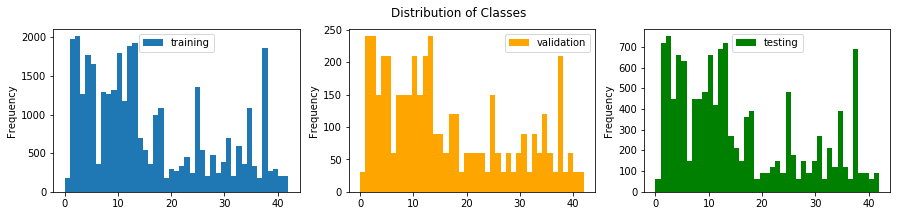

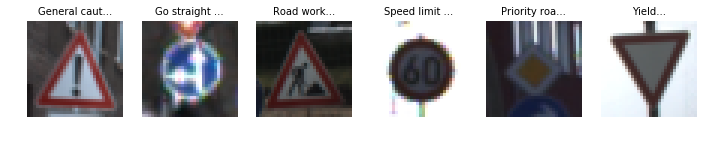

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import pandas as pd
import matplotlib.image as mpimg

label_names = pd.read_csv("signnames.csv") 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
pd.DataFrame(y_train, columns=['training']).plot.hist(bins=n_classes, ax = axes[0])
pd.DataFrame(y_valid, columns=['validation']).plot.hist(bins=n_classes, ax = axes[1], color='orange')
pd.DataFrame(y_test, columns=['testing']).plot.hist(bins=n_classes, ax = axes[2], color='green')
_ = plt.suptitle('Distribution of Classes')

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12,4))
rand_idx = np.random.randint(len(X_train), size=6)
for i in range(6):
    ax[i].imshow(X_train[rand_idx[i]])    
    ax[i].set_axis_off()
    #_ = plt.title('Sample Image - Class: %r' % y_train[rand_idx[i])
    print(label_names.iloc[y_train[rand_idx[i]]]['SignName'])
    ax[i].set_title(label_names.iloc[y_train[rand_idx[i]]]['SignName'][:12]+'...', fontsize=10)
    #plt.show()
    #print(label_names.iloc[y_train[rand_idx]])


----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model that learns to recognize traffic signs. Train and test model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation is the starting point.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 


size of training set: (34799, 32, 32, 1)
original max / min values: 255 0
normalized max / min values: 0.9919882812499998 -0.9733390625


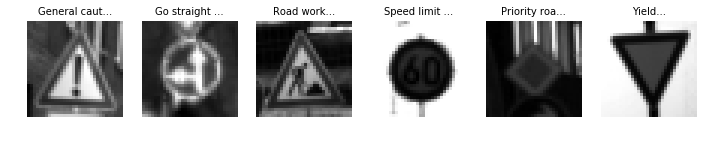

In [4]:
### normalize
def normalize(image_data):
    """
    - use minmax scaling
    """
    normalized = image_data.copy()
    normalized = (normalized - 128.0)/128
    return normalized

### convert to grayscale (optional) 
def convert2gray(image_data):
    """ 
    use Y' = 0.2989 R + 0.5870 G + 0.1140 B 
    """
    gray = image_data.copy()
    gray = np.dot(gray[...,:3], [0.2989, 0.5870, 0.1140])[:,:,:, np.newaxis]
    return gray

X_train_g = convert2gray(X_train)
X_test_g = convert2gray(X_test)
X_valid_g = convert2gray(X_valid)

X_train_n = normalize(X_train_g)
X_test_n = normalize(X_test_g)
X_valid_n = normalize(X_valid_g)
print('size of training set:', X_train_n.shape)
print('original max / min values:',np.max(X_train), np.min(X_train))
print('normalized max / min values:',np.max(X_train_n), np.min(X_train_n))

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12,4))
for i in range(6):
    ax[i].imshow(X_train_g[rand_idx[i]][:,:,0], cmap='gray')    
    ax[i].set_axis_off()
    ax[i].set_title(label_names.iloc[y_train[rand_idx[i]]]['SignName'][:12]+'...', fontsize=10)



### Model Architecture based on LeNet-5
Input

- The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Grayscale: C is 1.  RGB: C is 3.

Architecture
- Layer 1: Convolutional. The output shape should be 28x28x6 (changed to 12 layers).

    - Activation. Your choice of activation function.

    - Pooling. The output shape should be 14x14x6.

- Layer 2: Convolutional. The output shape should be 10x10x16 (changed to 32 layers).

    - Activation. Your choice of activation function.

    - Pooling. The output shape should be 5x5x16.

- Flatten
    - Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten.

- Layer 3: Fully Connected. This should have 120 outputs.

    - Activation. Your choice of activation function.

- Layer 4: Fully Connected. This should have 84 outputs.

    - Activation. Your choice of activation function.

- Layer 5: Fully Connected (Logits). This should have 10 outputs.

Output
- Return the result of the 2nd fully connected layer.



In [5]:
### architecture 
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# for tf.truncated_normal 
mu = 0.0
sigma = 0.1

# for weights -- height, width, depth_in, depth_out
# for padding -- 'VALID'
# out_height = ceil(float(in_height - filter_height + 1) / float(strides[1])
weights = {
    'c1': tf.Variable(tf.truncated_normal(shape = (5,5,1,12), mean = mu, stddev = sigma)),
    'c2': tf.Variable(tf.truncated_normal(shape = (5,5,12,32), mean = mu, stddev = sigma)),
    'f1': tf.Variable(tf.truncated_normal(shape = (5*5*32,120), mean = mu, stddev = sigma)),
    'f2': tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma)),
    'f3': tf.Variable(tf.truncated_normal(shape = (84,43), mean = mu, stddev = sigma))
}

biases = {
    'bc1':tf.Variable(tf.zeros(12)),
    'bc2':tf.Variable(tf.zeros(32)),
    'bf1':tf.Variable(tf.zeros(120)),
    'bf2':tf.Variable(tf.zeros(84)),
    'bf3':tf.Variable(tf.zeros(43))
}


def covNet(x, weights, biases, dropout = 1.0):
    # layer 1: convolutional - Input = 32x32x1. Output = 28x28x6Input = 32x32x1. Output = 28x28x6
    strides = [1,1,1,1]
    conv1 = tf.nn.conv2d(x, weights['c1'], strides=strides, padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    # activation
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.# Pooling. Input = 28x28x6. Output = 14x14x6.
    ksize = [1,2,2,1]
    strides = [1,2,2,1]
    conv1 = tf.nn.max_pool(conv1, ksize=ksize, strides=strides, padding='VALID')

    # layer 2: convolutional - Input = 14x14x6. Output = 10x10x16.
    strides = [1,1,1,1]
    conv2 = tf.nn.conv2d(conv1, weights['c2'], strides=strides, padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])
    # activation
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    ksize = [1,2,2,1]
    strides = [1,2,2,1]
    conv2 = tf.nn.max_pool(conv2, ksize=ksize, strides=strides, padding='VALID')

    # flatten. 5x5x16. Output = 400.
    fc1 = flatten(conv2)

    # layer 3: fully connected - Input = 400. Output = 120
    fc1 = tf.add(tf.matmul(fc1, weights['f1']), biases['bf1'])
    fc1 = tf.nn.relu(fc1)

    # layer 4: fully connected - Input = 120, Output = 84
    fc2 = tf.add(tf.matmul(fc1, weights['f2']), biases['bf2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)

    # layer 5: fully connected - Input = 84. Output = 43
    logits = tf.add(tf.matmul(fc2, weights['f3']), biases['bf3'])
    print('output shape:', logits.get_shape())

    return logits, conv1, conv2

## Features and Labels
- x is a placeholder for a batch of inputs
- y is a placeholder for a batch of output labels

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

In [7]:
learn_rate = 0.0005
logits, conv1, conv2 = covNet(x, weights, biases, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate) # Stochastic Gradient Descent
training_operation = optimizer.minimize(loss_operation)

def calc_loss(X_data, y_data, dropout_prob):
    num_examples = len(X_data)
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss = sess.run(loss_operation, feed_dict={x:batch_x, y:batch_y, keep_prob:dropout_prob})
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples


output shape: (?, 43)


Evaluation

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver= tf.train.Saver()

def evaluate(X_data, y_data, dropout_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x:batch_x, y:batch_y, keep_prob:dropout_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Train the model.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

training...

EPOCH 1 ...
Validation Accuracy = 0.615

EPOCH 2 ...
Validation Accuracy = 0.820

EPOCH 3 ...
Validation Accuracy = 0.869

EPOCH 4 ...
Validation Accuracy = 0.904

EPOCH 5 ...
Validation Accuracy = 0.916

EPOCH 6 ...
Validation Accuracy = 0.916

EPOCH 7 ...
Validation Accuracy = 0.926

EPOCH 8 ...
Validation Accuracy = 0.925

EPOCH 9 ...
Validation Accuracy = 0.938

EPOCH 10 ...
Validation Accuracy = 0.934

EPOCH 11 ...
Validation Accuracy = 0.936

EPOCH 12 ...
Validation Accuracy = 0.936

EPOCH 13 ...
Validation Accuracy = 0.930

EPOCH 14 ...
Validation Accuracy = 0.939

EPOCH 15 ...
Validation Accuracy = 0.935

EPOCH 16 ...
Validation Accuracy = 0.940

EPOCH 17 ...
Validation Accuracy = 0.939

EPOCH 18 ...
Validation Accuracy = 0.937

EPOCH 19 ...
Validation Accuracy = 0.943

EPOCH 20 ...
Validation Accuracy = 0.941

EPOCH 21 ...
Validation Accuracy = 0.950

EPOCH 22 ...
Validation Accuracy = 0.948

EPOCH 23 ...
Validation Accuracy = 0.946

EPOCH 24 ...
Validation Accura

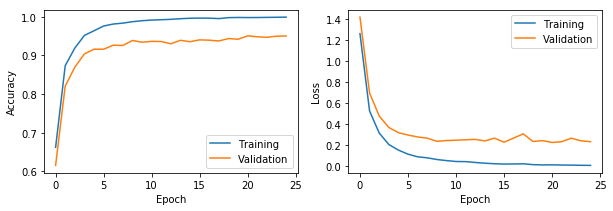

In [10]:
from sklearn.utils import shuffle

EPOCHS = 25
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_n)

    print('training...\n')
    acc_train = []
    acc_valid = []
    error_train = []
    error_valid = []
    for i in range(EPOCHS):
        X_data, y_data = shuffle(X_train_n, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_data[offset:end], y_data[offset:end]
            sess.run(training_operation, feed_dict = {x:batch_x, y:batch_y, keep_prob:0.5})
        
        training_accuracy = evaluate(X_train_n, y_train, 1.0)
        acc_train.append(training_accuracy)
        validation_accuracy = evaluate(X_valid_n, y_valid, 1.0)
        acc_valid.append(validation_accuracy)

        error_train.append(calc_loss(X_train_n, y_train, 1.0))
        error_valid.append(calc_loss(X_valid_n, y_valid, 1.0))

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()        

    saver.save(sess, './covnet')
    print('Model Saved')

    test_accuracy = evaluate(X_test_n, y_test, 1.0)
    print("Testing Accuracy = {:.3f}".format(test_accuracy))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
    ax[0].plot(acc_train, label='Training')
    ax[0].plot(acc_valid, label='Validation')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(error_train, label='Training')
    ax[1].plot(error_valid, label='Validation')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')    





---

## Step 3: Test a Model on New Images

Download at least five pictures of German traffic signs from the web and use the model to predict the traffic sign type.

### Load and Output the Images


(6, 32, 32, 1)


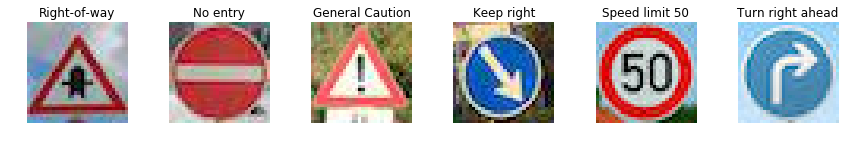

In [11]:
### Load the images and plot them.

X_additional = []
#print(os.listdir("additional/"))
sign_labels = []
for image_file in os.listdir("additional/"):
    if 'jpg' in image_file:
        image = mpimg.imread("additional/"+image_file)
        X_additional.append(image)
        sign_labels.append(image_file.split('.')[0])
X_additional = np.array(X_additional)
n_extras = len(X_additional)
fig, ax = plt.subplots(nrows=1, ncols=n_extras, figsize=(12,3))
fig.tight_layout()
for i in range(n_extras):
    ax[i].imshow(X_additional[i])
    ax[i].set_axis_off()
    ax[i].set_title(sign_labels[i])

X_additional_g = convert2gray(X_additional)
X_additional_n = normalize(X_additional_g)
print(X_additional_n.shape)


In [12]:
predict_logits = tf.placeholder(tf.float32)
predict_classes = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, './covnet')
    classes = sess.run(predict_classes, feed_dict={x: X_additional_n, keep_prob: 1.0})
    for class_label in np.argmax(classes, axis=1):
        print(label_names.iloc[class_label])

ClassId                                        11
SignName    Right-of-way at the next intersection
Name: 11, dtype: object
ClassId           17
SignName    No entry
Name: 17, dtype: object
ClassId                  18
SignName    General caution
Name: 18, dtype: object
ClassId             38
SignName    Keep right
Name: 38, dtype: object
ClassId                        1
SignName    Speed limit (30km/h)
Name: 1, dtype: object
ClassId                   33
SignName    Turn right ahead
Name: 33, dtype: object


### Analyze Performance

- All were classified correctly. The only error was on the value on the speed limit sign. In this case, the sign had a value of 50 km/h and the predicted value was 30 km/h.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

TopKV2(values=array([[2.5562334e-28, 6.1956504e-25, 6.4247522e-13, 1.0000000e+00,
        7.9652453e-24],
       [1.5146255e-16, 9.7716347e-15, 3.4979253e-16, 1.0000000e+00,
        3.5725725e-13],
       [5.0057900e-16, 7.0650370e-15, 2.1144562e-09, 4.6300519e-11,
        1.0000000e+00],
       [4.4237546e-36, 9.1976248e-36, 2.0588898e-32, 1.0000000e+00,
        9.1769874e-35],
       [3.1085543e-19, 2.0935262e-16, 6.2357958e-18, 9.9989772e-01,
        1.0222964e-04],
       [3.7687233e-08, 8.3205236e-07, 4.6900829e-04, 9.9952531e-01,
        4.8333022e-06]], dtype=float32), indices=array([[40, 27, 30, 11, 21],
       [34, 13, 33, 17,  9],
       [40, 11, 27, 26, 18],
       [12, 18, 25, 38, 20],
       [ 0,  4, 14,  1,  2],
       [25, 14, 35, 33,  1]], dtype=int32))


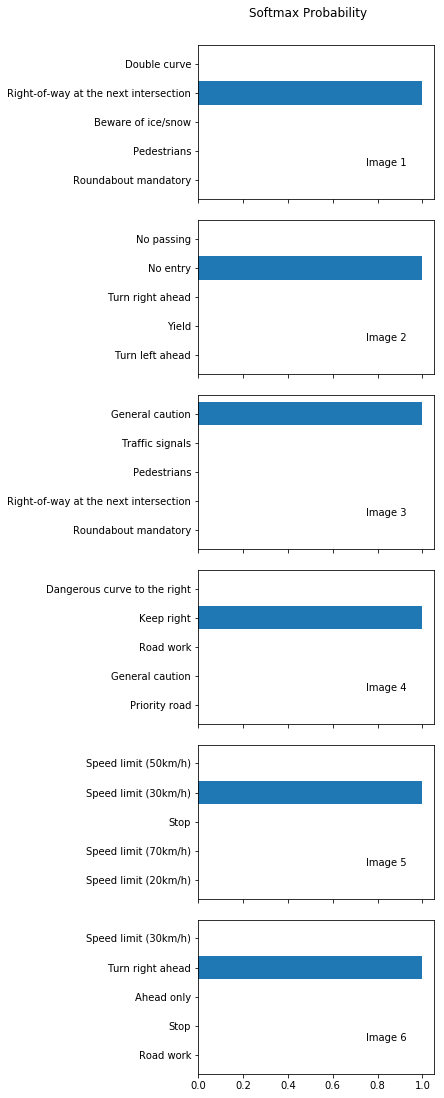

In [13]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.

results = tf.Session().run(tf.nn.top_k(classes, k=5, sorted=False))
print(results)

fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,16), sharex=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle("Softmax Probability")
for i in range(len(results[0])):
    ax[i].barh(range(len(results[0][i])), results[0][i])
    ylabels = [str(ans[1]) for ans in label_names.iloc[results[1][i]].values]
    #print(ylabels)
    ax[i].set_yticks(range(len(results[0][i])))
    ax[i].set_yticklabels(ylabels)
    ax[i].annotate('Image %r' % (i+1), (.75,.5))    


---

## Step 4: Visualize the Neural Network's State with Test Images

Plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. 


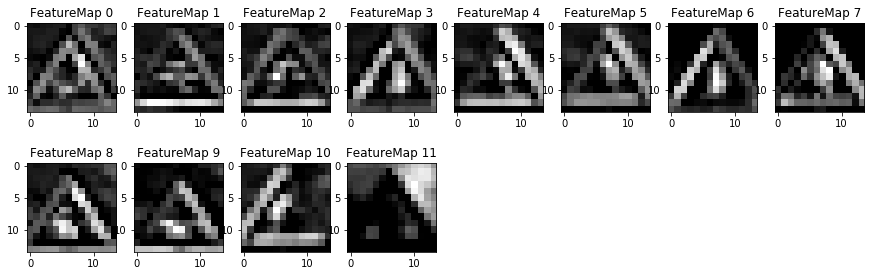

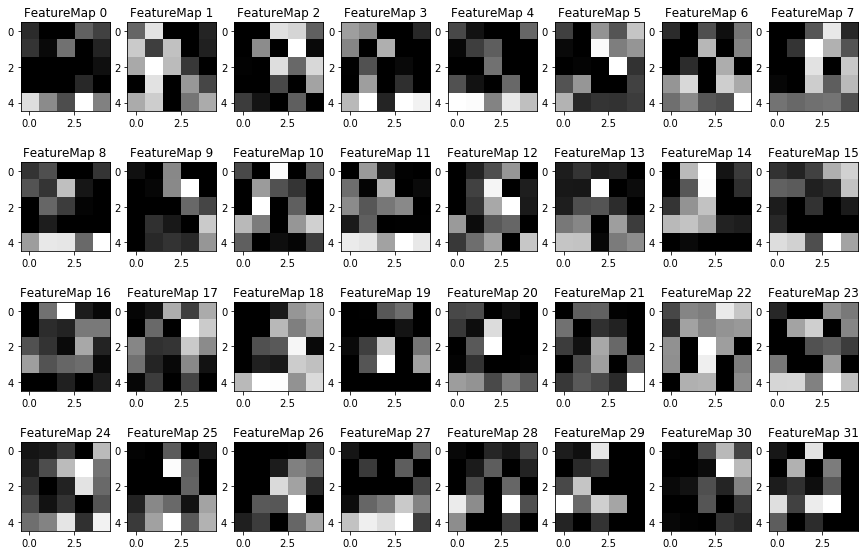

In [14]:
### Visualize network's feature maps.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, './covnet')
    #plt.figure()
    layer_images_1 = outputFeatureMap([X_additional_n[0]], conv1, plt_num=1)
    #plt.figure()
    layer_images_2 = outputFeatureMap([X_additional_n[0]], conv2, plt_num=2)